In [42]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
words = open('name.txt', 'r').read().splitlines()  # read names from file
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [44]:
len(words)

32033

In [45]:
# build the vocabulary of the characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))  # unique characters
stoi = { ch: i+1 for i, ch in enumerate(chars) }  # character to integer mapping
stoi['.'] = 0  # add a special character for padding
itos = { i: ch for ch, i in stoi.items() }  # integer to character mapping

In [46]:
# generate dataset 

block_size = 3  # context length: how many characters to look at to predict the next one
X, Y = [], []

for w in words[:5]:
    print(f'word: {w}')
    context = [0] * block_size  # start with a context of zeros (padding)
    for ch in w + ".":  # add a special character at the end
        ix = stoi[ch]
        X.append(context)  # append the context to the input
        Y.append(ix)  # append the target character
        print(f'context: {''.join(itos[i] for i in context)}, target: {itos[ix]}')
        context = context[1:] + [ix]  # update the context by removing the first character and adding the new one

X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

# initialize the network
g = torch.Generator().manual_seed(2147483647) # set random seed
W = torch.randn((27, 27), generator=g, requires_grad=True) # interested in the gradients of the weights

word: emma
context: ..., target: e
context: ..e, target: m
context: .em, target: m
context: emm, target: a
context: mma, target: .
word: olivia
context: ..., target: o
context: ..o, target: l
context: .ol, target: i
context: oli, target: v
context: liv, target: i
context: ivi, target: a
context: via, target: .
word: ava
context: ..., target: a
context: ..a, target: v
context: .av, target: a
context: ava, target: .
word: isabella
context: ..., target: i
context: ..i, target: s
context: .is, target: a
context: isa, target: b
context: sab, target: e
context: abe, target: l
context: bel, target: l
context: ell, target: a
context: lla, target: .
word: sophia
context: ..., target: s
context: ..s, target: o
context: .so, target: p
context: sop, target: h
context: oph, target: i
context: phi, target: a
context: hia, target: .


In [47]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [ ]:
# construct the lookup table
# We have 27 possible characters (26 letters + 1 for padding), and want to crammed them into a 2 dimensional space
# So we create a 27x2 matrix where each row corresponds to a character's embedding
C = torch.randn((27, 2))

In [49]:
C.shape

torch.Size([27, 2])

In [50]:
C[5] # equivalent to F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([0.6098, 0.1214])

In [51]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [31]:
emb[13, 2] # equivalent to using the X[13, 2] as an index to get the embedding vector
X[13, 2] # = 1
C[1] # = emb[13, 2]

tensor([-0.0818, -1.0367])

In [ ]:
# construct the hidden layer
# the input parameters number of every neural at the hidden layer is 6 (3 context characters * 2 embedding dimensions), and we construct a hidden layer with 100 neurons
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

In [58]:
# we want emb @ W1 + b1, but we can't do that directly because emb is of shape (N, 3, 2) and W1 is of shape (6, 100)
# so we need to reshape emb to (N, 6

# remove a dimension by unbinding the second dimension (3 context characters) and then concatenate them
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [61]:
# another efficient way to do this is to use view, it doesn't allocate new memory, just changes the shape
# -1 means "infer the size of this dimension based on the other dimensions"
emb.view(emb.shape[0], -1).shape

torch.Size([32, 6])

In [66]:
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # this is the hidden layer output
h.shape

torch.Size([32, 100])

In [68]:
# construct the final layer
# the hidden layer output is of shape (N, 100), and we want to map it to the output layer of shape (N, 27), because we have 27 possible characters
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [71]:
logits = h @ W2 + b2  # this is the output layer
counts = logits.exp()  # convert logits to counts
probs = counts / counts.sum(1, keepdim=True)  # convert counts to probabilities
probs

tensor([[6.4754e-06, 1.9698e-06, 1.0230e-08, 5.0876e-07, 1.9002e-06, 3.6529e-04,
         1.9373e-02, 9.0992e-06, 4.1839e-05, 3.5549e-04, 1.8947e-05, 4.1066e-02,
         7.3381e-01, 5.6573e-06, 2.6627e-08, 2.0744e-06, 6.9948e-04, 9.5731e-02,
         3.0842e-03, 8.8265e-02, 2.6530e-10, 1.0996e-09, 3.3233e-07, 3.0356e-05,
         1.5450e-02, 4.4870e-07, 1.6862e-03],
        [1.3305e-11, 2.5496e-10, 2.4087e-11, 1.0992e-11, 2.3981e-06, 4.3513e-09,
         2.0229e-09, 2.8756e-06, 2.1448e-08, 7.2838e-06, 5.7898e-07, 5.8718e-02,
         1.0990e-02, 4.1920e-07, 2.7499e-06, 8.4436e-09, 3.5361e-07, 9.2851e-01,
         2.5382e-10, 2.3448e-07, 3.2023e-10, 9.6878e-10, 4.3005e-07, 1.6597e-08,
         3.0451e-04, 1.3715e-03, 9.2999e-05],
        [2.9805e-03, 1.4171e-09, 1.7995e-04, 1.5852e-09, 2.2596e-03, 1.0163e-04,
         9.8196e-01, 1.3174e-05, 1.4989e-03, 5.7815e-03, 5.1857e-04, 4.4604e-04,
         1.3809e-03, 9.7113e-04, 4.0225e-11, 4.4271e-06, 9.5547e-04, 5.7182e-04,
         3.6295e-

In [72]:
# now we can use Y to get the correct probabilities for the target characters which generated fromt the network
probs[torch.arange(len(Y)), Y]  # this is the probability of the target

tensor([3.6529e-04, 4.1920e-07, 9.7113e-04, 7.7119e-05, 1.2290e-06, 2.0744e-06,
        1.8975e-02, 3.2562e-09, 2.8684e-07, 2.1897e-06, 2.8094e-05, 1.4466e-06,
        1.9698e-06, 5.1490e-08, 1.4051e-08, 5.8583e-10, 3.5549e-04, 1.8063e-08,
        4.8548e-09, 5.0114e-06, 3.0891e-07, 1.9017e-10, 6.7725e-13, 5.2603e-06,
        4.6235e-05, 8.8265e-02, 6.4772e-10, 2.5657e-09, 2.8712e-02, 1.0329e-08,
        5.2496e-06, 4.1378e-04])

In [73]:
loss = -probs[torch.arange(len(Y)), Y].log()  # negative log likelihood loss
loss.mean()  # average loss over the batch

tensor(13.7622)

In [ ]:
# ----- rewrite the above code ----- #

In [84]:
# generate dataset 

block_size = 3  # context length: how many characters to look at to predict the next one
X, Y = [], []

for w in words:
    context = [0] * block_size  # start with a context of zeros (padding)
    for ch in w + ".":  # add a special character at the end
        ix = stoi[ch]
        X.append(context)  # append the context to the input
        Y.append(ix)  # append the target character
        context = context[1:] + [ix]  # update the context by removing the first character and adding the new one

X = torch.tensor(X, dtype=torch.long)
Y = torch.tensor(Y, dtype=torch.long)

In [85]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [124]:
# --------- initialize the network --------
g = torch.Generator().manual_seed(2147483647)  # set random seed
C = torch.randn((27, 2), generator=g)  # character embeddings
W1 = torch.randn(6, 100, generator=g)  # hidden layer weights
b1 = torch.randn(100, generator=g)  # hidden layer biases
W2 = torch.randn(100, 27, generator=g)  # output layer weights
b2 = torch.randn(27, generator=g)  # output layer biases
parameters = [C, W1, b1, W2, b2]  # list of all parameters

for p in parameters:
    p.requires_grad = True  # we want to compute gradients for all parameters

In [125]:
sum(p.numel() for p in parameters)  # total number of parameters

3481

In [ ]:
# ---------- initialize end ----------

In [95]:
for _ in range(1000):  # run for 10 iterations
    # NOTE: it's much better to have an approximate gradient and just make more steps than it is to evaluate the exact gradient
    # and take fewer steps
    ix = torch.randint(0, len(X), (32,), generator=g)  # random batch of indices
    # forward pass
    emb = C[X[ix]]  # lookup table for the characters
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # hidden layer output
    logits = h @ W2 + b2  # output layer
    # counts = logits.exp()  # convert logits to counts
    # probs = counts / counts.sum(1, keepdim=True)  # convert counts to probabilities
    # loss = -probs[torch.arange(len(Y)), Y].log()  # negative log likelihood loss
    # loss.mean()  # average loss over the batch
    loss = F.cross_entropy(logits, Y[ix])  # this is the same as the above loss, but more efficient and numerically stable

    # backward pass
    for p in parameters:
        p.grad = None  # zero the gradients
    loss.backward()  # compute gradients

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad  # update parameters with a learning rate of 0.1
print(loss.item())  # print the loss value

2.3644161224365234


In [96]:
# global loss
emb = C[X]  # lookup table for the characters
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # hidden layer output
logits = h @ W2 + b2  # output layer
loss = F.cross_entropy(logits, Y)  # compute the loss
loss

tensor(2.6146, grad_fn=<NllLossBackward0>)

In [ ]:
# ---------- learning rate adjustment --------------
# first, determine a reasonable learning rate ranges.

lre = torch.linspace(-3, 0, 1000)  # learning rate range
lrs = 10 ** lre  # learning rates


In [119]:
lri = []
lossi = []
for i in range(1000):  # run for 10 iterations
    # NOTE: it's much better to have an approximate gradient and just make more steps than it is to evaluate the exact gradient
    # and take fewer steps
    ix = torch.randint(0, len(X), (32,), generator=g)  # random batch of indices
    # forward pass
    emb = C[X[ix]]  # lookup table for the characters
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # hidden layer output
    logits = h @ W2 + b2  # output layer
    # counts = logits.exp()  # convert logits to counts
    # probs = counts / counts.sum(1, keepdim=True)  # convert counts to probabilities
    # loss = -probs[torch.arange(len(Y)), Y].log()  # negative log likelihood loss
    # loss.mean()  # average loss over the batch
    loss = F.cross_entropy(logits, Y[ix])  # this is the same as the above loss, but more efficient and numerically stable

    # backward pass
    for p in parameters:
        p.grad = None  # zero the gradients
    loss.backward()  # compute gradients

    # update parameters
    lr = lrs[i]
    for p in parameters:
        p.data += -lr * p.grad  # update parameters with a learning rate of 0.1
    
    lri.append(lre[i])  # store the learning rate
    lossi.append(loss.item())  # store the loss value

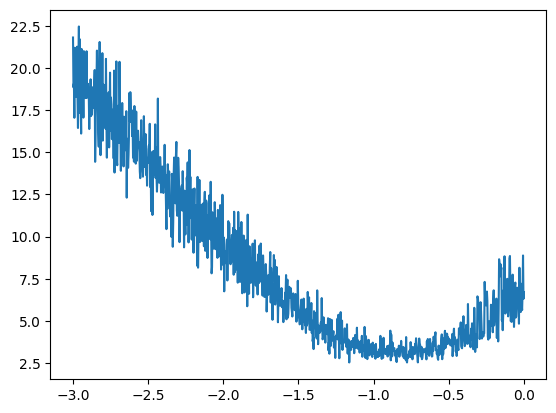

In [120]:
# so a good learning rate is around 0.1
plt.plot(lri, lossi)

In [126]:
# ---------------- split the dataset into training, validation, and test sets ---------------- #
# training split, dev or validation split, test split
# NOTE: 80% training use to train models, 10% validaton use to train hyperparameters like the size of hidden layer, or the size of embedding, 10% test use to evluate the final model
def build_dataset(words):
    block_size = 3  # context length: how many characters to look at to predict the next one
    X, Y = [], []

    for w in words:
        context = [0] * block_size  # start with a context of zeros (padding)
        for ch in w + ".":  # add a special character at the end
            ix = stoi[ch]
            X.append(context)  # append the context to the input
            Y.append(ix)  # append the target character
            context = context[1:] + [ix]  # update the context by removing the first character and adding the new one

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)

    return X, Y

import random
random.seed(42)  # for reproducibility
random.shuffle(words)  # shuffle the words to get a random order
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words))  # 10% for validation

Xtr, Ytr = build_dataset(words[:n1])  # training set
Xdev, Ydev = build_dataset(words[n1:n2])  # validation set
Xte, Yte = build_dataset(words[n2:])  # test set

In [99]:
len(Xtr), len(Ytr), len(Xdev), len(Ydev), len(Xte), len(Yte)

(182625, 182625, 22655, 22655, 22866, 22866)

In [127]:
stepi = []
lossi = []

for i in range(30000):  # run for 10 iterations
    # it's much better to have an approximate gradient and just make more steps than it is to evaluate the exact gradient
    # and take fewer steps
    ix = torch.randint(0, len(Xtr), (32,), generator=g)  # random batch of indices
    # forward pass
    emb = C[Xtr[ix]]  # lookup table for the characters
    h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # hidden layer output
    logits = h @ W2 + b2  # output layer
    # counts = logits.exp()  # convert logits to counts
    # probs = counts / counts.sum(1, keepdim=True)  # convert counts to probabilities
    # loss = -probs[torch.arange(len(Y)), Y].log()  # negative log likelihood loss
    # loss.mean()  # average loss over the batch
    loss = F.cross_entropy(logits, Ytr[ix])  # this is the same as the above loss, but more efficient and numerically stable

    # backward pass
    for p in parameters:
        p.grad = None  # zero the gradients
    loss.backward()  # compute gradients

    # update parameters
    for p in parameters:
        p.data += -0.1 * p.grad  # update parameters with a learning rate of 0.1

    stepi.append(i)  # store the step number
    lossi.append(loss.item())  # store the loss value
print(loss.item())  # print the loss value

2.639935255050659


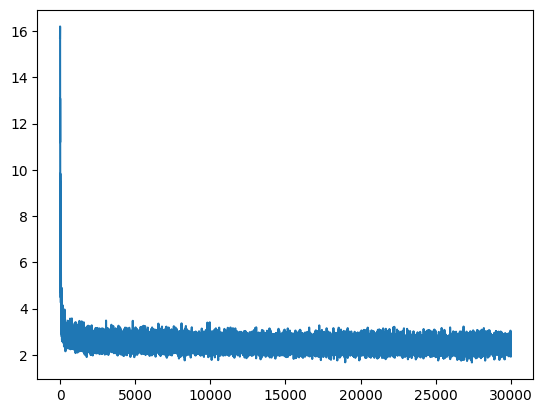

In [128]:
# mini batchs introduce the noises.
plt.plot(stepi, lossi)

In [108]:
# using test set to evaluate the model
emb = C[Xte]  # lookup table for the characters
h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)  # hidden layer output
logits = h @ W2 + b2  # output layer
loss = F.cross_entropy(logits, Yte)  # compute the loss
loss

tensor(2.4153, grad_fn=<NllLossBackward0>)